<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

In [1]:
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np

from typing import Union

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette='summer')
from transformers import AutoTokenizer, AutoModel
import transformers

import nltk
import re
import string
import copy
import gc

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Обработка данных

In [3]:
df = pd.read_csv("/kaggle/input/problems-data/data_problems.xlsx - Sheet1.csv").drop("Unnamed: 0", axis=1)

In [4]:
from sklearn.model_selection import train_test_split

train_df , eval_df = train_test_split(df, test_size=0.2, shuffle=True)

name2label = {name : i for (i, name) in enumerate(set(df['Тема']))}
label2name = {i : name for (i, name) in enumerate(set(df['Тема']))}
num_labels = len(name2label)

In [5]:
def preprocess_text(text):
    nums_filtered_text = re.sub('[\r\n]', '', text.lower())
    punct_filtered_text = ''.join(
        [ch for ch in nums_filtered_text if ch not in string.punctuation]
    )

    return punct_filtered_text

In [6]:
def prepare_data(dataframe : pd.DataFrame):
    data = copy.copy(dataframe)
    data['Тема'] = [name2label[name] for name in dataframe['Тема']]
    labels = np.array(data['Тема'])
    texts = [[preprocess_text(data['Задача'].iloc[i])] for i in range(len(data['Задача']))]
    return (texts, labels)

In [7]:
class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long)
        }

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [8]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, model, num_labels):
        super().__init__()
        self.backbone = model
        self.output_features = self.backbone.encoder.layer[1].output.dense.out_features
        self.linear1 = nn.Linear(self.output_features, self.output_features // 2)
        self.non_linear = nn.Tanh()
        self.linear2 = nn.Linear(self.output_features // 2, num_labels)

    def forward(self, inputs, attention):
        outputs = self.backbone(inputs , attention)
        pooler_output = outputs['pooler_output']
        attention_output = outputs['attentions']  
        outputs = self.linear1(pooler_output)
        outputs = self.linear2(self.non_linear(outputs))
        return (outputs, attention_output)

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [9]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [10]:
def train_transformer(transformer_model, train_loader, eval_loader, num_epochs=3, freeze_backbone=True):
    model = copy.deepcopy(transformer_model)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    if freeze_backbone:
        model = freeze_backbone_function(model)
    
    loss_epochs = {'eval' : [], 'train' : []}

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0
        for (i, batch) in enumerate(train_loader):
            optimizer.zero_grad()
            logit = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))[0]
            loss = criterion(logit, batch['label'].long().to(device))
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        
        
        if (epoch % 2) == 0:
            model.eval()
            eval_loss = 0
            with torch.no_grad():
                for (i, batch) in enumerate(eval_loader):
                    logit = model(batch['input_ids'].to(device), batch['attention_mask'].to(device))[0]
                    loss = criterion(logit, batch['label'].long().to(device))
                    eval_loss += loss.item()
            
            print("epoch :", epoch, "loss train:", train_loss/len(train_loader), "eval loss:", eval_loss/len(eval_loader))
            
            loss_epochs['eval'].append(eval_loss/len(eval_loader))
            loss_epochs['train'].append(train_loss/len(train_loader))
        torch.cuda.empty_cache()
        gc.collect()

    return (model, loss_epochs)

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [11]:
def calc_loss_graph(losses, name):
    plt.plot(np.arange(0, len(losses['eval'])*2, 2), losses['eval'], label='eval', c='r')
    plt.plot(np.arange(0, len(losses['eval'])*2, 2), losses['train'], label='train', c='g')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(name)
    plt.legend()
    plt.show()

In [12]:
rubert = TransformerClassificationModel(AutoModel.from_pretrained("cointegrated/rubert-tiny2", output_attentions=True), num_labels).to(device)
tokenizer_rubert =  transformers.AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [13]:
train_data = prepare_data(train_df)
eval_data = prepare_data(eval_df)

train_dataset = MyDataset(train_data[0], train_data[1], tokenizer_rubert)
eval_dataset = MyDataset(eval_data[0], eval_data[1], tokenizer_rubert)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=True)

In [14]:
num_epochs = 40

rubert_freeze, losses = train_transformer(rubert, train_loader, eval_loader, num_epochs, freeze_backbone=True)

  0%|          | 0/40 [00:00<?, ?it/s]

epoch : 0 loss train: 1.91664945898634 eval loss: 1.8889924576788237
epoch : 2 loss train: 1.79744614796205 eval loss: 1.781151421142347
epoch : 4 loss train: 1.6982669550361056 eval loss: 1.6936646916649558
epoch : 6 loss train: 1.624904850215623 eval loss: 1.6335757465073557
epoch : 8 loss train: 1.5781985729029684 eval loss: 1.5963230927785237
epoch : 10 loss train: 1.5505812339710467 eval loss: 1.5716498801202485
epoch : 12 loss train: 1.5265623900023373 eval loss: 1.5522505008813106
epoch : 14 loss train: 1.5064812636736669 eval loss: 1.5347650195613052
epoch : 16 loss train: 1.4912160147320142 eval loss: 1.5186088554786914
epoch : 18 loss train: 1.4751055349003186 eval loss: 1.5039076082634204
epoch : 20 loss train: 1.459406686551643 eval loss: 1.4897086042346377
epoch : 22 loss train: 1.4472597846479127 eval loss: 1.475896625807791
epoch : 24 loss train: 1.4342667117263332 eval loss: 1.4631287437496763
epoch : 26 loss train: 1.4185658196608226 eval loss: 1.451110789270112
epoch 

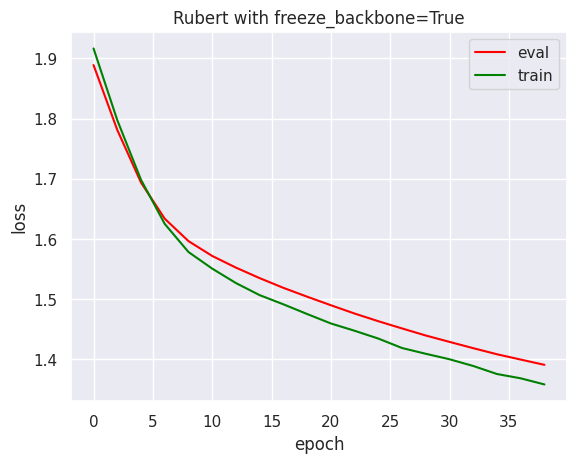

In [15]:
calc_loss_graph(losses, 'Rubert with freeze_backbone=True')

In [16]:
num_epochs = 18
rubert_not_freeze, losses = train_transformer(rubert, train_loader, eval_loader, num_epochs, freeze_backbone=False)

  0%|          | 0/18 [00:00<?, ?it/s]

epoch : 0 loss train: 1.695063649704962 eval loss: 1.5504927346200654
epoch : 2 loss train: 1.2917268176873524 eval loss: 1.2652127959511497
epoch : 4 loss train: 1.1155302280729467 eval loss: 1.161712231058063
epoch : 6 loss train: 1.0105114804975914 eval loss: 1.0868094039685798
epoch : 8 loss train: 0.9346872206890222 eval loss: 1.0478801907915059
epoch : 10 loss train: 0.8651004316228809 eval loss: 1.0347362449674895
epoch : 12 loss train: 0.8094589279005022 eval loss: 1.0217865217815747
epoch : 14 loss train: 0.7548842825221292 eval loss: 1.0150734240358525
epoch : 16 loss train: 0.7083018115072539 eval loss: 1.0266101450631113


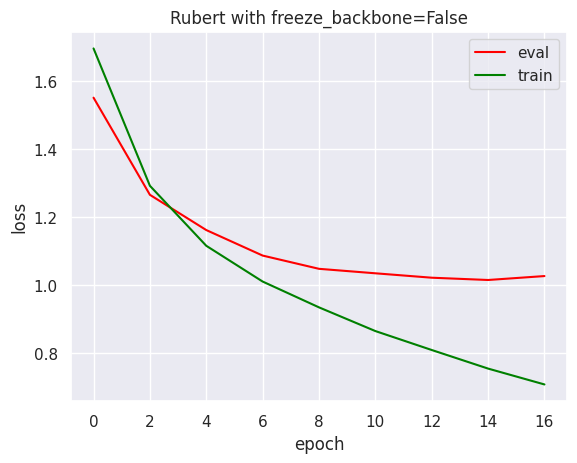

In [17]:
calc_loss_graph(losses, 'Rubert with freeze_backbone=False')

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [18]:
tokenizer_tbs = transformers.AutoTokenizer.from_pretrained("tbs17/MathBert")
tbs_model = TransformerClassificationModel(AutoModel.from_pretrained("tbs17/MathBert", output_attentions=True), num_labels).to(device)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [19]:
train_data = prepare_data(train_df)
eval_data = prepare_data(eval_df)

train_dataset = MyDataset(train_data[0], train_data[1], tokenizer_tbs)
eval_dataset = MyDataset(eval_data[0], eval_data[1], tokenizer_tbs)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=True)

In [20]:
num_epochs = 24

tbs_freeze, losses = train_transformer(tbs_model, train_loader, eval_loader, num_epochs, freeze_backbone=True)

  0%|          | 0/24 [00:00<?, ?it/s]

epoch : 0 loss train: 1.6371445854504902 eval loss: 1.6211082790837144
epoch : 2 loss train: 1.5701343028834371 eval loss: 1.599568941376426
epoch : 4 loss train: 1.5512993660840122 eval loss: 1.5801435275511309
epoch : 6 loss train: 1.5325526441588546 eval loss: 1.5603274576591724
epoch : 8 loss train: 1.5147911761746262 eval loss: 1.5439792221242732
epoch : 10 loss train: 1.5015657580260076 eval loss: 1.526902097644228
epoch : 12 loss train: 1.4867791840524385 eval loss: 1.5146702961488203
epoch : 14 loss train: 1.4759624952619725 eval loss: 1.5038287061633486
epoch : 16 loss train: 1.4646444564515895 eval loss: 1.495542631004796
epoch : 18 loss train: 1.4555443597562385 eval loss: 1.4850231264576768
epoch : 20 loss train: 1.4479967464100232 eval loss: 1.477791352705522
epoch : 22 loss train: 1.4402824938297272 eval loss: 1.471553455699574


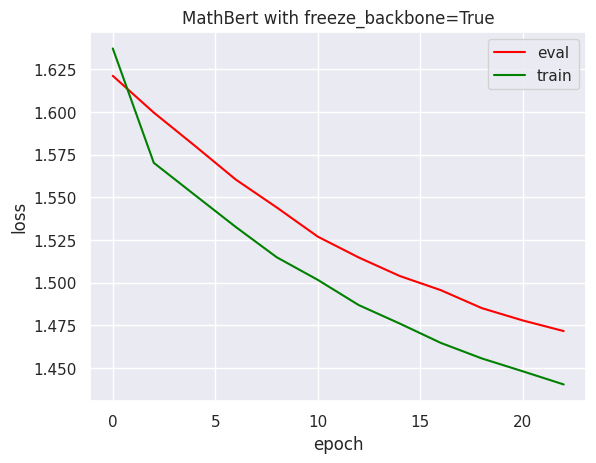

In [21]:
calc_loss_graph(losses, 'MathBert with freeze_backbone=True')

In [23]:
num_epochs = 10

tbs_not_freeze, losses = train_transformer(tbs_model, train_loader, eval_loader, num_epochs, freeze_backbone=False)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch : 0 loss train: 1.4532754656040308 eval loss: 1.3020752921248928
epoch : 2 loss train: 1.0793843165491566 eval loss: 1.1705001014651675
epoch : 4 loss train: 0.9368072865587292 eval loss: 1.1473635850530681
epoch : 6 loss train: 0.8077761314131997 eval loss: 1.1866487860679626
epoch : 8 loss train: 0.6911119640325055 eval loss: 1.2539025220003994


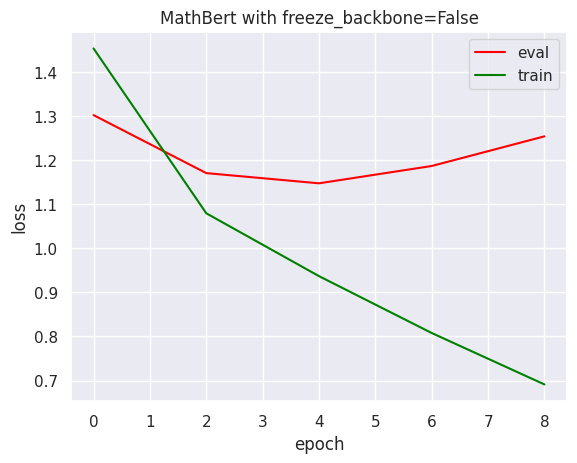

In [24]:
calc_loss_graph(losses, 'MathBert with freeze_backbone=False')

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [25]:
def draw_layer_attention_maps(text, model, tokenizer, num_attention_layer=0, num_attention_head=0):
    with torch.no_grad():
        inputs = tokenizer(preprocess_text(text), return_tensors='pt')
        attention_output = model.backbone(inputs['input_ids'].to(device), inputs['attention_mask'].to(device))['attentions'][num_attention_layer] 
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

        attention_weights = attention_output[0][num_attention_head].cpu().numpy()
        plt.figure(figsize=(10,10))
        fig = sns.heatmap(attention_weights, xticklabels=tokens, yticklabels=tokens, square=True)
    return fig

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).


In [40]:
s = next(iter(train_dataset))['text']

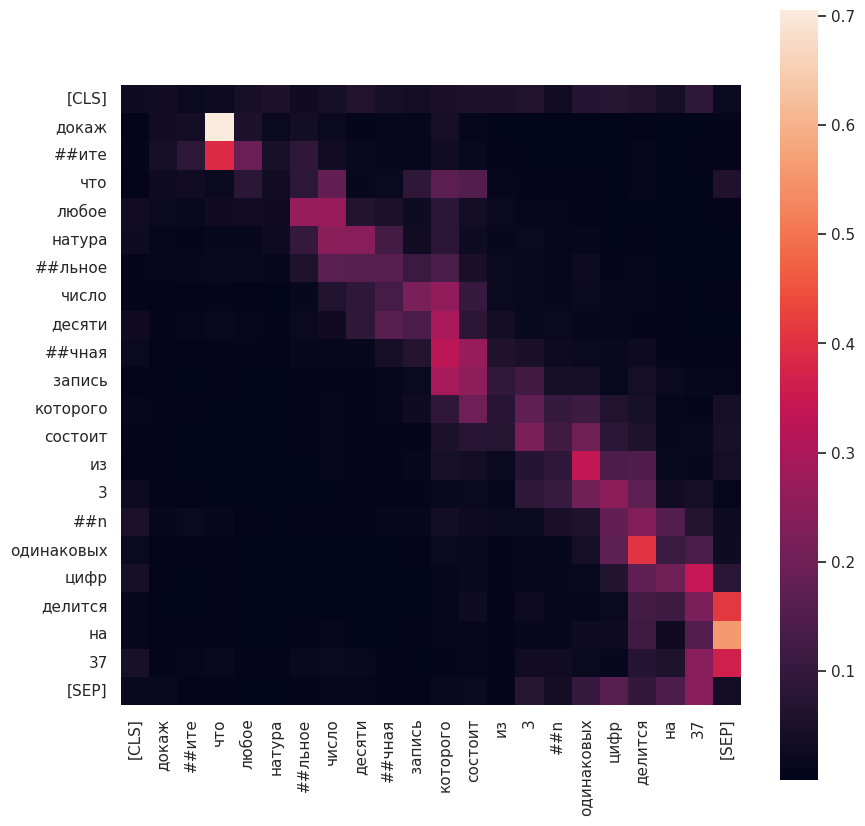

In [41]:
fig = draw_layer_attention_maps(s, rubert, tokenizer_rubert, 0, 7);
plt.show()

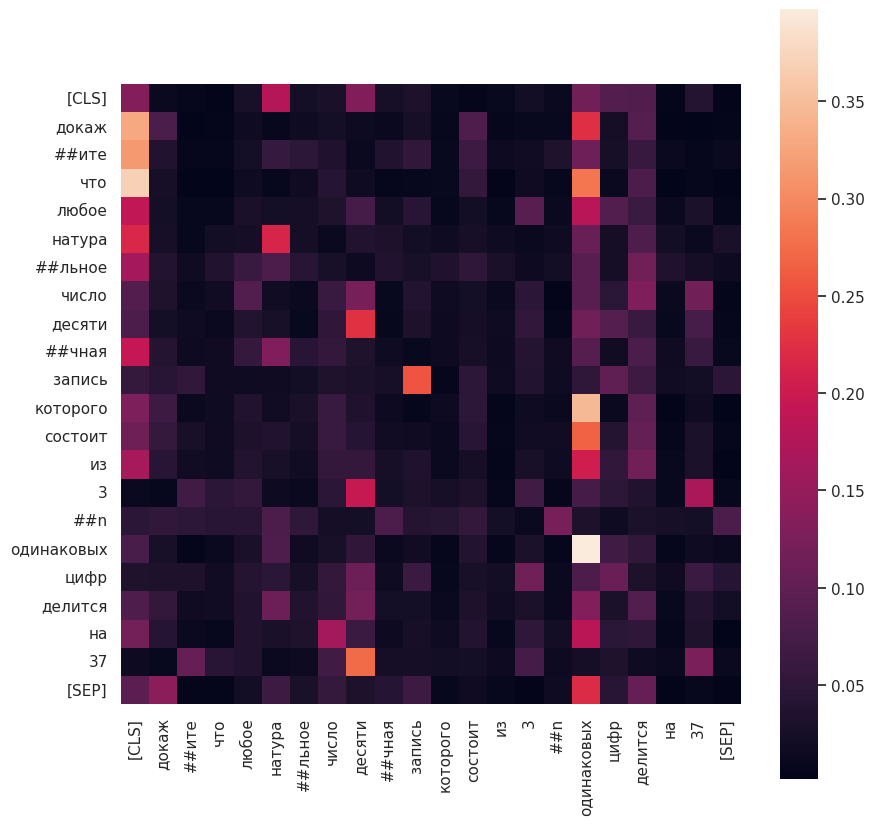

In [34]:
fig = draw_layer_attention_maps(s, rubert, tokenizer_rubert, 0, 3);
plt.show()

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. 

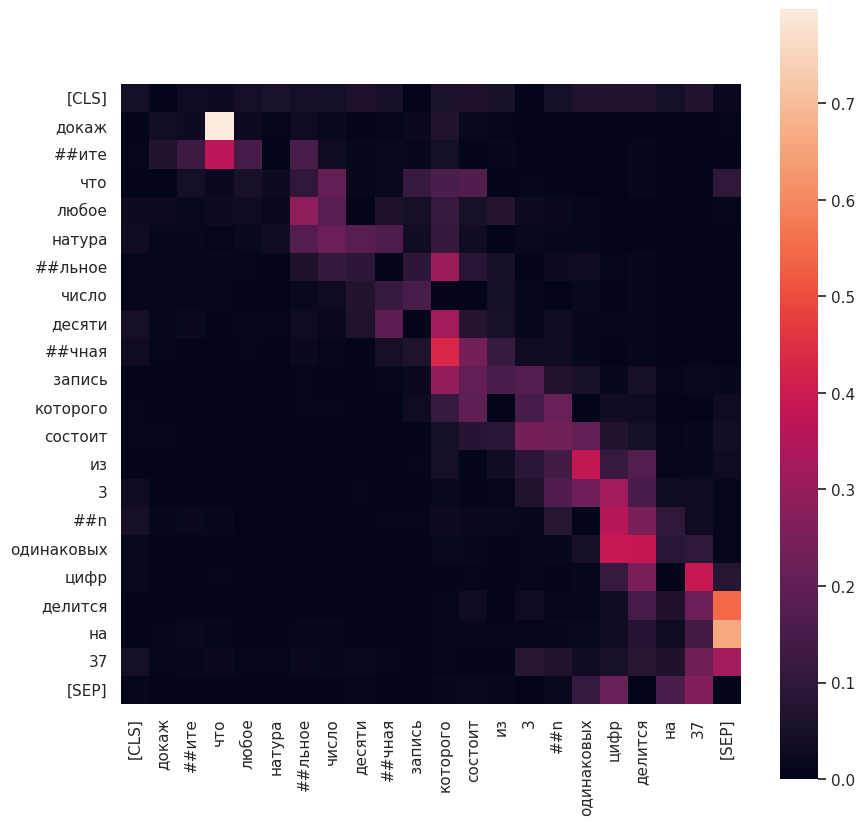

In [42]:
fig = draw_layer_attention_maps(s, rubert_freeze, tokenizer_rubert, 0, 7);
plt.show()

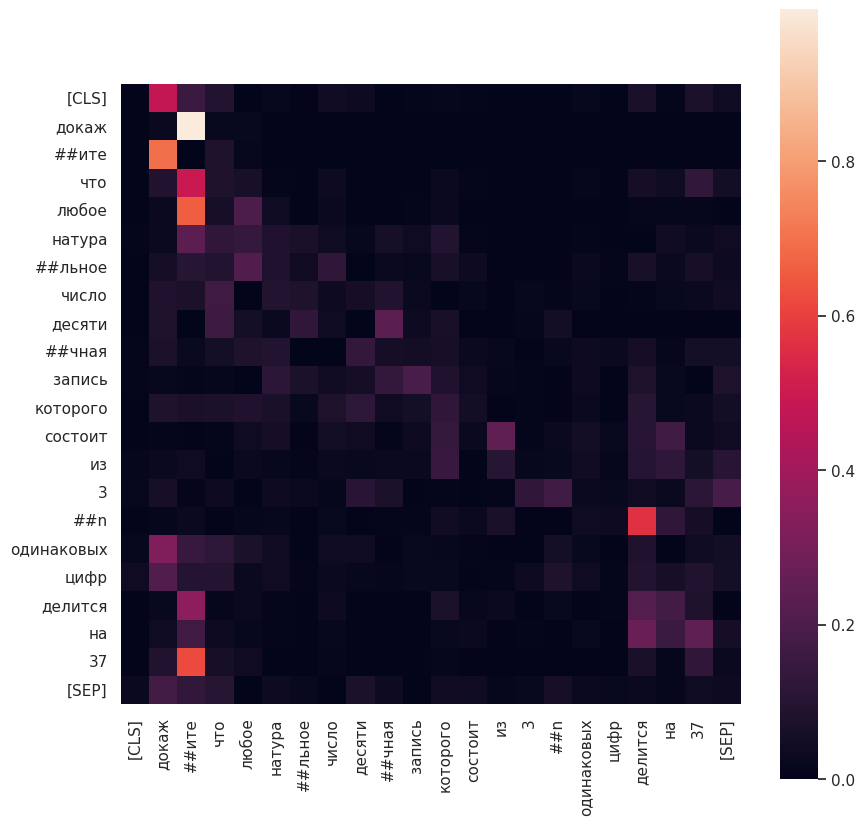

In [43]:
fig = draw_layer_attention_maps(s, rubert_not_freeze, tokenizer_rubert, 2, 9);
plt.show()